# (4) QCoDes can also be used to implement meta-instruments

Here we want to represent a sample which uses virtual gates to controll gate voltages

In [1]:
import qcodes

import numpy as np
import xarray as xr

## Implement an abstract sample instrument

In [2]:
class SampleInstrument(qcodes.Instrument):
    def __init__(self, name, virtual_gates, physical_gates, matrix, **kwargs):
        super().__init__(name, **kwargs)

        self.add_parameter(
            name="matrix", initial_value=matrix, set_cmd=None, get_cmd=None
        )
        self.add_parameter(
            name="matrix_inv",
            initial_value=np.linalg.inv(matrix),
            set_cmd=None,
            get_cmd=None,
        )

        self.add_parameter(
            name="physical_gates", parameter_class=self.GateList, gates=physical_gates
        )

        self.add_parameter(
            name="voltage_vector",
            initial_value=np.zeros((len(physical_gates))),
            set_cmd=None,
            get_cmd=None,
        )
        self.add_parameter(
            name="virtual_vector",
            initial_value=np.zeros((len(physical_gates))),
            set_cmd=None,
            get_cmd=None,
        )

        for i, vgate in enumerate(virtual_gates):
            self.add_parameter(vgate, self.VirtualGate, gate_index=i)

        self._get_virtual()

    def _set_virtual(self, index, value):
        self.virtual_vector()[index] = value
        self.voltage_vector(np.dot(self.matrix(), self.virtual_vector()))

        for param, value_i in zip(self.physical_gates(), self.voltage_vector()):
            param(value_i)

    def _get_virtual(self, index=None):
        self.voltage_vector(np.array([param() for param in self.physical_gates()]))
        self.virtual_vector(np.dot(self.matrix_inv(), self.voltage_vector()))

        if index is not None:
            return self.virtual_vector()[index]

    def snapshot_base(
        self, update: bool = True, params_to_skip_update: tuple = None
    ) -> dict:
        return super().snapshot_base(
            update=True, params_to_skip_update=params_to_skip_update
        )

    def get_idn(self):
        return {}

    class VirtualGate(qcodes.Parameter):
        def __init__(self, name, gate_index, **kwargs):
            super().__init__(name, **kwargs)

            self.gate_index = gate_index

        def set_raw(self, value):
            self.instrument._set_virtual(self.gate_index, value)

        def get_raw(self):
            return self.instrument._get_virtual(self.gate_index)

    class GateList(qcodes.Parameter):
        def __init__(self, name, gates, **kwargs):
            super().__init__(name, **kwargs)

            self.gates = gates

        def get_raw(self):
            return self.gates

## Initialize a physical and sample instrument

In [3]:
qcodes.Instrument.close_all()

pinst = qcodes.Instrument("pinst", label="pinst")
pinst.get_idn = lambda: {}
pinst.ask = lambda x: x

pinst.add_parameter(
    "pg1", qcodes.Parameter, get_cmd=None, set_cmd=None, initial_value=0
)
pinst.add_parameter(
    "pg2", qcodes.Parameter, get_cmd=None, set_cmd=None, initial_value=0
)

In [4]:
sample = SampleInstrument(
    "sample_inst",
    virtual_gates=["vg1", "vg2"],
    physical_gates=[pinst.pg1, pinst.pg2],
    matrix=np.array([[0.25, 0.75], [0.75, 0.25]]),
)

## Inspect the instruments and do things

In [5]:
station = qcodes.Station(pinst, sample)

for component in station.components.values():
    component.print_readable_snapshot()

pinst:
	parameter value
--------------------------------------------------------------------------------
IDN :	{'vendor': '*IDN?', 'model': None, 'serial': None, 'firmware': None} 
pg1 :	0 
pg2 :	0 
sample_inst:
	parameter     value
--------------------------------------------------------------------------------
IDN            :	{} 
matrix         :	[[0.25 0.75]
 [0.75 0.25]] 
matrix_inv     :	[[-0.5  1.5]
 [ 1.5 -0.5]] 
physical_gates :	[<qcodes.parameters.parameter.Parameter: pg1 at 4551292448>,...
vg1            :	0 
vg2            :	0 
virtual_vector :	[0. 0.] 
voltage_vector :	[0 0] 


In [6]:
pinst.pg1(0)
pinst.pg2(0)

In [7]:
pinst.pg1(1)

In [8]:
sample.vg1(2)

## Perform a measurement

In [9]:
from pathlib import Path

qcodes.initialise_or_create_database_at(str(Path.home()) + "/Downloads/my_db.db")

Starting experimental run with id: 3. Using 'qcodes.dataset.do1d'


  0%|          | 0/100 [00:00<?, ?it/s]

(virtual_sweep #3@/Users/maxbeer/Downloads/my_db.db
 --------------------------------------------------
 sample_inst_vg1 - numeric
 pinst_pg1 - numeric
 pinst_pg2 - numeric,
 (<Axes: title={'center': 'Run #3, Experiment testing virtual gates (some_sample)'}, xlabel='vg1', ylabel='pg1'>,
  <Axes: title={'center': 'Run #3, Experiment testing virtual gates (some_sample)'}, xlabel='vg1', ylabel='pg2'>),
 (None, None))

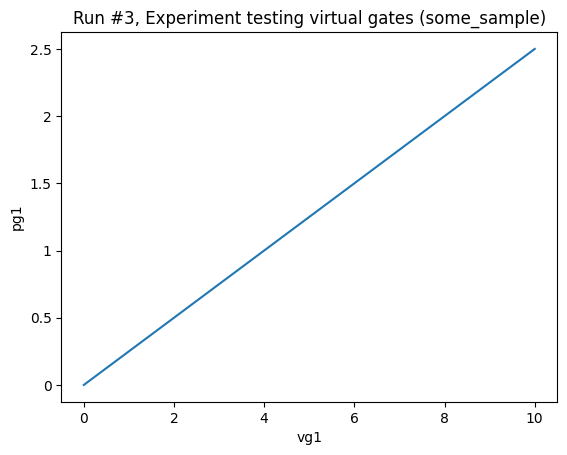

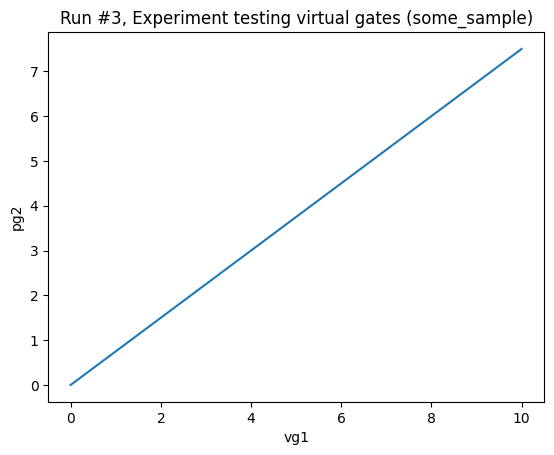

In [10]:
import qcodes.dataset

exp = qcodes.load_or_create_experiment("testing virtual gates")

qcodes.dataset.do1d(
    sample.vg1,
    0,  # start
    10,  # stop
    100,  # n_points
    0.01,  # delay
    pinst.pg1,
    pinst.pg2,
    measurement_name="virtual_sweep",
    exp=exp,
    do_plot=True,
    show_progress=True,
)